In [1]:
import logging
import yaml
import matplotlib.pyplot as plt
from scipy.stats.distributions import lognorm
import numpy as np
import pandas as pd
import os.path
import pyrheautils as pu
from collections import deque, defaultdict
from facilitybase import CareTier
from tools_util import readModelInputs, getFacDict
import phacsl.utils.formats.csv_tools as csv_tools
import math


In [2]:
runDesc = '/home/welling/git/pyRHEA_github/src/sim/week_run_OC.yaml'

inputDict = readModelInputs(runDesc)
facDict = getFacDict(inputDict)

totD = defaultdict(int)
nFacD = defaultdict(int)
for fac, rec in facDict.items():
    nFacD[rec['category']] += 1
    totD[rec['category']] += rec['meanPop']['value']
print 'totD: ', totD
print 'nFacD: ', nFacD

# Drop annoying community entries
dropL = []
for abbrev, rec in facDict.items():
    if rec['category'] == 'COMMUNITY':
        dropL.append(abbrev)
for abbrev in dropL:
    del facDict[abbrev]
print facDict.keys()

totD:  defaultdict(<type 'int'>, {'NURSINGHOME': 7131.619999999999, 'HOSPITAL': 3365.6, 'LTAC': 297.6, 'COMMUNITY': 2728818})
nFacD:  defaultdict(<type 'int'>, {'NURSINGHOME': 67, 'HOSPITAL': 22, 'LTAC': 4, 'COMMUNITY': 580})
['CSNC', 'HOAG', 'LPAL', 'GGMC', 'MANO', 'COVI', 'CVSB', 'SCGL', 'CVLH', 'PACI', 'BGSJ', 'SEAC', 'SJUD', 'ANHC', 'FLAG', 'FVRH', 'KNOT', 'SMMC', 'EVER', 'HGOR', 'WAMC', 'PALM', 'LAKE', 'COLL', 'GGCH', 'STAN', 'FPCC', 'GORD', 'MSLG', 'CHAP', 'FOCC', 'KAIA', 'HVAL', 'CARE', 'SCRT', 'SNMR', 'BEAC', 'VICT', 'PKVW', 'UCIM', 'VIVA', 'LHAB', 'HSOU', 'WAEC', 'TOWN', 'HELP', 'OCGB', 'EXTW', 'ROYL', 'LEIS', 'ACNC', 'ALTA', 'WINA', 'NSUB', 'COCT', 'FREE', 'PREG', 'ELIZ', 'PSUP', 'CVPL', 'TERR', 'PANA', 'MESA', 'LAMC', 'BPNC', 'WINF', 'PVIS', 'GREE', 'HVCC', 'ORRH', 'EDNA', 'ANRG', 'BVCC', 'LPIH', 'NNRC', 'BGYL', 'KINB', 'KINO', 'KINW', 'CAPO', 'ATCC', 'MISS', 'ANGL', 'ALAM', 'OCMM', 'WLNT', 'RGNT', 'QUAK', 'NEWO', 'GPCC', 'SJOS', 'PLAC', 'HBHO']


In [3]:
mMinusFName = pu.pathTranslate('$(MODELDIR)/Updated_MRSA-Stratified_LOS_Distributions_for_RHEA_2.0_-_10-15-2018_MSRAMINUS_LOS_LE365.csv')
with open(mMinusFName, 'rU') as f:
          mMinusKeys, mMinusRecs = csv_tools.parseCSV(f)
print mMinusKeys
mMinusD = {rec['CODE']: rec for rec in mMinusRecs}

[u'CODE', u'N', u'LN_MEAN', u'LN_STD DEV', u'LN_MINIMUM', u'LN_MAXIMUM', u'LN_25TH PCTL', u'LN_75TH PCTL', u'LN_QUARTILE RANGE', u'']


In [4]:
mPlusFName = pu.pathTranslate('$(MODELDIR)/Updated_MRSA-Stratified_LOS_Distributions_for_RHEA_2.0_-_10-15-2018_MSRAPLUS_LOS_LE365.csv')
with open(mPlusFName, 'rU') as f:
          mPlusKeys, mPlusRecs = csv_tools.parseCSV(f)
print mPlusKeys
mPlusD = {rec['CODE']: rec for rec in mPlusRecs}

[u'CODE', u'N', u'LN_MEAN', u'LN_STD DEV', u'LN_MINIMUM', u'LN_MAXIMUM', u'LN_25TH PCTL', u'LN_75TH PCTL', u'LN_QUARTILE RANGE', u'']


In [5]:
abbrev = 'FVRH'
losMu = mMinusD[abbrev]['LN_MEAN']
losSigma = mMinusD[abbrev]['LN_STD DEV']
losRV = lognorm(losSigma, scale=math.exp(losMu), loc=0.0)
print losRV.mean()

5.162746096033781


In [6]:
hospNames = [abbrev for abbrev in mMinusD
             if mMinusD[abbrev]['LN_MEAN'] != '' and facDict[abbrev]['category'] == 'HOSPITAL']
hospNames.sort()
print hospNames
ltacNames = [abbrev for abbrev in mMinusD
             if mMinusD[abbrev]['LN_MEAN'] != '' and facDict[abbrev]['category'] == 'LTAC']
ltacNames.sort()
print ltacNames

[u'ANGL', u'ANRG', u'CHAP', u'FVRH', u'GGMC', u'HBHO', u'HGOR', u'HOAG', u'KAIA', u'LAMC', u'LPIH', u'MISS', u'MSLG', u'OCGB', u'OCMM', u'PLAC', u'SCGL', u'SJOS', u'SJUD', u'SMMC', u'UCIM', u'WAMC']
[u'COLL', u'HSOU', u'KINB', u'KINW']


In [7]:
for fac in hospNames + ltacNames:
    losMu = mMinusD[fac]['LN_MEAN']
    losSigma = mMinusD[fac]['LN_STD DEV']
    mMinusD[fac]['crv'] = lognorm(losSigma, scale=math.exp(losMu), loc=0.0)

    losMu = mPlusD[fac]['LN_MEAN']
    losSigma = mPlusD[fac]['LN_STD DEV']
    mPlusD[fac]['crv'] = lognorm(losSigma, scale=math.exp(losMu), loc=0.0)


In [8]:
NSAMP = 5

def genWts(dct, nameL):
    nNm = len(nameL)
    nTot = sum([dct[fac]['N'] for fac in nameL])
    wts = np.zeros(nNm)
    for idx, fac in enumerate(nameL):
        wts[idx] = float(dct[fac]['N'])/float(nTot)
    return wts

nPlusWts = genWts(mPlusD, hospNames)
#print nPlusWts
#print sum(nPlusWts)
nMinusWts = genWts(mMinusD, hospNames)
#print sum(nMinusWts)

In [9]:
def sampleMixture(dct, nameL):
    wts = genWts(dct, nameL)
    randIndices = np.random.choice(len(nameL), size=NSAMP, p=wts)
    sampA = np.empty((NSAMP, len(nameL)))
    for idx, fac in enumerate(nameL):
        sampA[:, idx] = dct[fac]['crv'].rvs(NSAMP)
    mixV = np.fromiter([sampA[col, randIndices[col]] for col in xrange(NSAMP)], dtype=np.float)
    return mixV
#nPlusRVs = [mPlusD[idx]['crv'] for idx in xrange(len(hospNames))]
#samps = 
samps = sampleMixture(mPlusD, hospNames)
#print samps

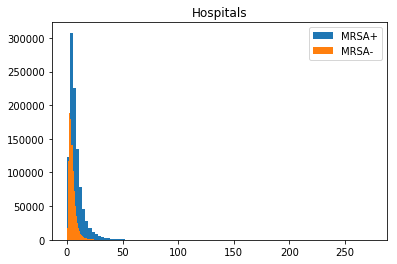

In [10]:
NSAMP = 1000000
plt.hist(sampleMixture(mPlusD, hospNames), bins=100, label='MRSA+')
plt.hist(sampleMixture(mMinusD, hospNames), bins=100, label='MRSA-')
plt.title('Hospitals')
plt.legend()
plt.show()

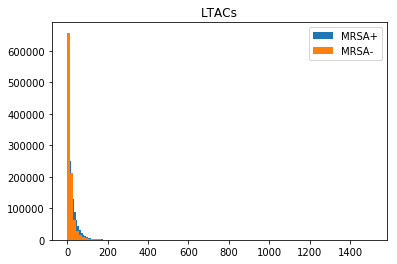

In [11]:
NSAMP = 1000000
plt.hist(sampleMixture(mPlusD, ltacNames), bins=100, label='MRSA+')
plt.hist(sampleMixture(mMinusD, ltacNames), bins=100, label='MRSA-')
plt.title('LTACs')
plt.legend()
plt.show()

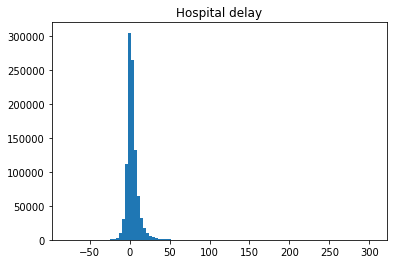

mean:  3.359660235850788
stdv:  7.648198556814007


In [12]:
NSAMP = 1000000
delayV = sampleMixture(mPlusD, hospNames) - sampleMixture(mMinusD, hospNames)
plt.hist(delayV, bins=100)
plt.title('Hospital delay')
plt.show()
print 'mean: ', np.mean(delayV)
print 'stdv: ', np.std(delayV)

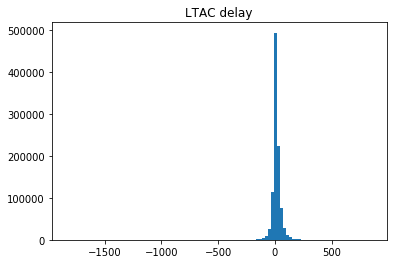

mean:  15.022576933643187
stdv:  36.93461927586869


In [13]:
NSAMP = 1000000
delayV = sampleMixture(mPlusD, ltacNames) - sampleMixture(mMinusD, ltacNames)
plt.hist(delayV, bins=100)
plt.title('LTAC delay')
plt.show()
print 'mean: ', np.mean(delayV)
print 'stdv: ', np.std(delayV)